In [1]:
import pandas as pd

print("--- Starting Merge Process ---")

try:
    # Load both original CSVs
    df_annotations = pd.read_csv("content/annotations.csv")
    df_bbox = pd.read_csv("content/bbox.csv")
    merged_path = "content/merged_turtle_data.csv"

    print("Loaded annotations.csv and bbox.csv")

    # Merge them
    # 'path' in annotations.csv is the same as 'image_name' in bbox.csv
    df_merged = pd.merge(df_annotations, df_bbox, left_on='path', right_on='image_name')

    print(f"Merge successful. New table has {len(df_merged)} rows.")

    # Save the new merged file
    df_merged.to_csv(merged_path, index=False)

    print("\nSuccessfully created 'merged_turtle_data.csv'!")
    print("\nColumns in new file:")
    print(df_merged.columns.to_list())

    print("\nHead of merged file:")
    print(df_merged.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'annotations.csv' and 'bbox.csv' are in your /content/ directory.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Starting Merge Process ---
Loaded annotations.csv and bbox.csv
Merge successful. New table has 160 rows.

Successfully created 'merged_turtle_data.csv'!

Columns in new file:
['identity', 'path', 'orientation', 'date', 'label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_name', 'image_width', 'image_height']

Head of merged file:
  identity               path orientation        date label_name  bbox_x  \
0   G16-25   leftIMG_0958.JPG        left  22_06_2018       head    1137   
1   G16-25  rightIMG_0961.JPG       right  22_06_2018       head    2764   
2   G16-25   leftIMG_1300.JPG        left  08_07_2020       head    1331   
3   G16-25  rightIMG_1280.JPG       right  08_07_2020       head    2676   
4     t551   leftIMG_1084.JPG        left  07_06_2023       head    1919   

   bbox_y  bbox_width  bbox_height         image_name  image_width  \
0     953         607          523   leftIMG_0958.JPG         5472   
1    1232         843          664  rightIMG_0961.

**Step 1: Preprocessing**

In [43]:
import cv2
import numpy as np

def preprocess_image(image):
    """
    Adaptive exposure + high contrast enhancement for turtle face patterns.
    Works for dark, bright, and well-lit images.
    """

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- NEW: Adaptive Gamma Correction ---
    mean_intensity = np.mean(gray)

    # Dark image → gamma < 1 (brighten)
    # Bright image → gamma > 1 (darken)
    gamma = 0.7 if mean_intensity < 110 else (1.4 if mean_intensity > 160 else 1.0)
    gamma_corrected = np.power(gray / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # 2) CLAHE (increase local contrast)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gamma_corrected)

    # 3) Unsharp Mask (edge emphasis)
    blur = cv2.GaussianBlur(enhanced, (7,7), 0)
    sharp = cv2.addWeighted(enhanced, 1.6, blur, -0.6, 0)

    # 4) Bilateral filter (preserve patch edges, smooth skin texture)
    final = cv2.bilateralFilter(sharp, d=9, sigmaColor=35, sigmaSpace=35)

    return final

**Step 2: Head Detection (ROI)**

In [44]:
def get_head_roi(image, bbox):
    """Extracts the Region of Interest (ROI) based on the bounding box."""
    x, y, w, h = [int(v) for v in bbox]
    roi = image[y:y+h, x:x+w]
    return roi

**Step 3: Rotate (Registration)**

In [45]:
# def register_head(image, orientation, landmarks):
#     """
#     Registers a head image and its corresponding landmarks.
#     If orientation is 'right', it flips both the image and 
#     the landmarks horizontally.
#     """
#     landmarks = np.asarray(landmarks)
    
#     if orientation == 'right':
#         # 1. Flip image
#         registered_image = cv2.flip(image, 1)
#         # 2. Get width
#         image_width = image.shape[1]
#         # 3. Copy landmarks
#         registered_landmarks = np.copy(landmarks)
#         # 4. Flip x-coordinate
#         registered_landmarks[:, 0] = (image_width - 1) - registered_landmarks[:, 0]
        
#         return registered_image, registered_landmarks
#     else:
#         return image, landmarks


In [ ]:
import cv2
import numpy as np
import math

# def compute_rotation_angle(left_eye, right_eye):
#     """Calculate the tilt angle between eyes (in degrees)."""
#     dx = right_eye[0] - left_eye[0]
#     dy = right_eye[1] - left_eye[1]
#     return math.degrees(math.atan2(dy, dx))

def rotate_and_align(image, left_eye, right_eye, nose_tip):
    """
    Rotate image so eyes are horizontal, nose below eye midpoint.
    This does NOT flip left/right orientation.
    """
    # 1. Compute rotation center (midpoint between eyes)
    eye_center = (
        (left_eye[0] + right_eye[0]) / 2,
        (left_eye[1] + right_eye[1]) / 2
    )

    # 2. Compute rotation angle
    angle = compute_rotation_angle(left_eye, right_eye)

    # 3. Rotate around eye center
    M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # 4. Rotate points too (for later cropping/alignment checks)
    def rotate_point(pt):
        x, y = pt
        x_new = M[0, 0]*x + M[0, 1]*y + M[0, 2]
        y_new = M[1, 0]*x + M[1, 1]*y + M[1, 2]
        return (x_new, y_new)

    left_eye_r = rotate_point(left_eye)
    right_eye_r = rotate_point(right_eye)
    nose_tip_r = rotate_point(nose_tip)

    return rotated, left_eye_r, right_eye_r, nose_tip_r

In [47]:
def crop_aligned_face(rotated, left_eye_r, right_eye_r, nose_tip_r, output_size=256):
    """
    Center crop around eyes/nose region after rotation.
    """
    cx = int((left_eye_r[0] + right_eye_r[0]) / 2)
    cy = int((left_eye_r[1] + right_eye_r[1]) / 2)
    
    # Add vertical offset (so nose tip is included)
    cy = int((cy + nose_tip_r[1]) / 2)

    half = output_size // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = cx + half, cy + half

    # Handle border conditions
    h, w = rotated.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    cropped = rotated[y1:y2, x1:x2]
    return cropped

**Step 4: Segmentation**

In [48]:
import cv2
import numpy as np

def segment_pattern(image):
    """
    Advanced segmentation สำหรับลายเต่า
    * เน้นให้ลายคม + เส้นติดกัน *
    """
 
    # 1) เพิ่ม contrast แบบรักษา texture
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
 
    # 2) ลด noise แต่คงลาย
    filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=30, sigmaSpace=30)
 
    # 3) Otsu Threshold
    _, segmented = cv2.threshold(
        filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
 
    # 4) เชื่อมเส้นลายให้ติดกัน
    kernel = np.ones((3,3), np.uint8)
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)
 
    # 5) ทำให้ mask เรียบขึ้นนิดหนึ่ง
    segmented = cv2.GaussianBlur(segmented, (3,3), 0.3)
 
    # เติมเส้นให้ต่อเนื่องมากขึ้นแบบไม่บวมมาก
    segmented = cv2.dilate(segmented, np.ones((1,1), np.uint8), iterations=1)
 
    return segmented

**Demostration**

In [49]:
import pandas as pd
import numpy as np
import cv2  # OpenCV library
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Define paths ---
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# --- Load the MERGED metadata into the 'df' variable ---
try:
    df = pd.read_csv(CSV_FILE)
    print(f"✅ Successfully loaded {CSV_FILE} with {len(df)} records.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find {CSV_FILE}.")
    print("Please make sure you ran Step A first.")
except Exception as e:
    print(f"⚠️ An error occurred loading the CSV: {e}")

✅ Successfully loaded content/merged_turtle_data.csv with 160 records.


✅ Loaded 160 records from content/merged_turtle_data.csv
🔍 Detected classes: []
⚠️ No nose_tip found.
⚠️ Missing nose_tip for leftIMG_0597.jpg, skipping.
🔍 Detected classes: ['left_eye']
⚠️ No nose_tip found.
⚠️ Missing nose_tip for leftIMG_9544.jpeg, skipping.
🔍 Detected classes: []
⚠️ No nose_tip found.
⚠️ Missing nose_tip for rightIMG_9280.jpg, skipping.
🔍 Detected classes: ['nose_tip']
↩️ Rotation angle (to horizontal): 173.87°


<Figure size 1600x1200 with 0 Axes>

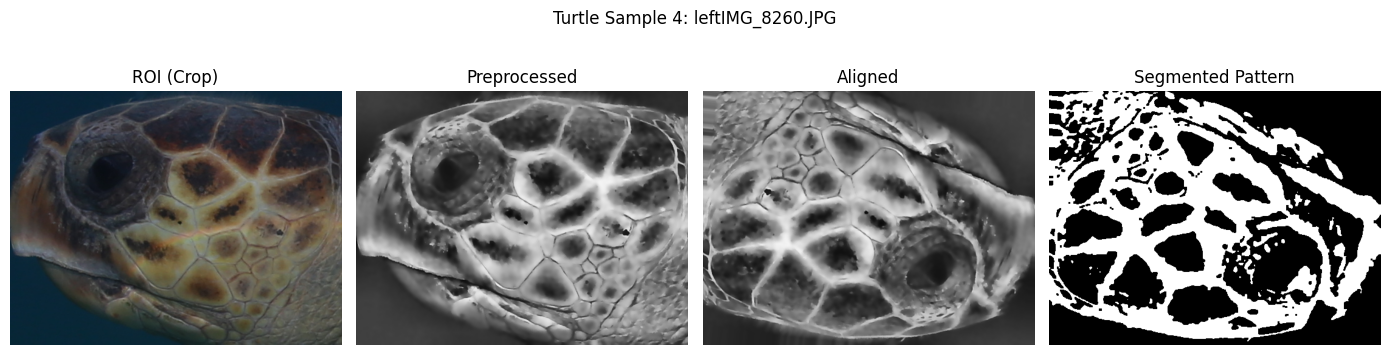

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
from inference_sdk import InferenceHTTPClient

# --- Define paths ---
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# --- Load metadata ---
df = pd.read_csv(CSV_FILE)
print(f"✅ Loaded {len(df)} records from {CSV_FILE}")

# ==============================================================
#                      HELPER FUNCTIONS
# ==============================================================

def preprocess_image(image):
    """Enhance contrast and texture visibility for turtle facial patterns."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    gamma = 0.7 if mean_intensity < 110 else (1.4 if mean_intensity > 160 else 1.0)
    gamma_corrected = np.power(gray / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gamma_corrected)
    blur = cv2.GaussianBlur(enhanced, (7,7), 0)
    sharp = cv2.addWeighted(enhanced, 1.6, blur, -0.6, 0)
    final = cv2.bilateralFilter(sharp, d=9, sigmaColor=35, sigmaSpace=35)
    return final


def get_head_roi(image, bbox):
    x, y, w, h = [int(v) for v in bbox]
    return image[y:y+h, x:x+w]


def extract_turtle_keypoints(result_json):
    """Extract only the nose_tip coordinate from Roboflow result."""
    preds = result_json[0]["predictions"]["predictions"]

    classes = [p["class"] for p in preds]
    print("🔍 Detected classes:", classes)

    nose_tip = None
    for p in preds:
        if p["class"] == "nose_tip" and p.get("keypoints"):
            keypoints = sorted(p["keypoints"], key=lambda k: -k["confidence"])
            nose_tip = (int(keypoints[0]["x"]), int(keypoints[0]["y"]))
            break

    if nose_tip is None:
        print("⚠️ No nose_tip found.")

        return None

    return nose_tip


def rotate_and_align(image, nose_tip):
    """
    Rotate image so that the line from the ROI center to the nose tip
    lies perfectly horizontal (0° relative to x-axis).
    If nose_tip is missing, return the original image unchanged.
    """
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    # --- Handle missing keypoint gracefully ---
    if nose_tip is None or len(nose_tip) != 2:
        print("⚠️ No valid nose_tip provided, skipping rotation.")
        return image

    dx = nose_tip[0] - center[0]
    dy = nose_tip[1] - center[1]

    # Compute rotation angle relative to horizontal
    angle = math.degrees(math.atan2(dy, dx))
    print(f"↩️ Rotation angle (to horizontal): {-angle:.2f}°")

    # Perform rotation
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(
        image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    return rotated


def segment_pattern(image):
    """Advanced segmentation สำหรับลายเต่า"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=30, sigmaSpace=30)
    _, segmented = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)
    segmented = cv2.GaussianBlur(segmented, (3,3), 0.3)
    segmented = cv2.dilate(segmented, np.ones((1,1), np.uint8), iterations=1)
    return segmented


def get_keypoints_from_roboflow(roi):
    client = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key="njWzK2heOkrQaGgn2CKY"
    )
    tmp_path = "temp_roi.jpg"
    cv2.imwrite(tmp_path, roi)

    try:
        result = client.run_workflow(
            workspace_name="final-project953494-qwata",
            workflow_id="turtle-landmark",
            images={"image": tmp_path},
            use_cache=True
        )
        return extract_turtle_keypoints(result)
    except Exception as e:
        print(f"⚠️ Roboflow inference failed: {e}")
        return None

# ==============================================================
#                 MAIN VISUALIZATION LOOP
# ==============================================================

samples = df.sample(4, random_state=42)
plt.figure(figsize=(16, 12))

for i, row in enumerate(samples.itertuples(), 1):
    img_path = os.path.join(IMAGE_DIR, row.path)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing image: {img_path}")
        continue

    image = cv2.imread(img_path)
    roi = get_head_roi(image, [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height])
    preprocessed = preprocess_image(roi)

    nose_tip = get_keypoints_from_roboflow(preprocessed)
    if nose_tip is None:
        print(f"⚠️ Missing nose_tip for {row.path}, skipping.")
        continue

    rotated = rotate_and_align(preprocessed, nose_tip)
    segmented = segment_pattern(rotated)

    # Plot in a single row
    stages = [roi, preprocessed, rotated, segmented]
    titles = ['ROI (Crop)', 'Preprocessed', 'Aligned', 'Segmented Pattern']

    plt.figure(figsize=(14, 4))
    for j in range(4):
        plt.subplot(1, 4, j+1)
        if j < 3:
            plt.imshow(cv2.cvtColor(stages[j], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(stages[j], cmap='gray')
        plt.title(titles[j])
        plt.axis('off')
    plt.suptitle(f"Turtle Sample {i}: {row.path}")
    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()

✅ Loaded 160 records from content/merged_turtle_data.csv

================= ROBFLOW RESULT (compact) =================

📦 Number of detection blocks: 0
⚠️ No keypoints found in detection.
⚠️ No keypoints at all, skipping rotation.


<Figure size 1600x1200 with 0 Axes>

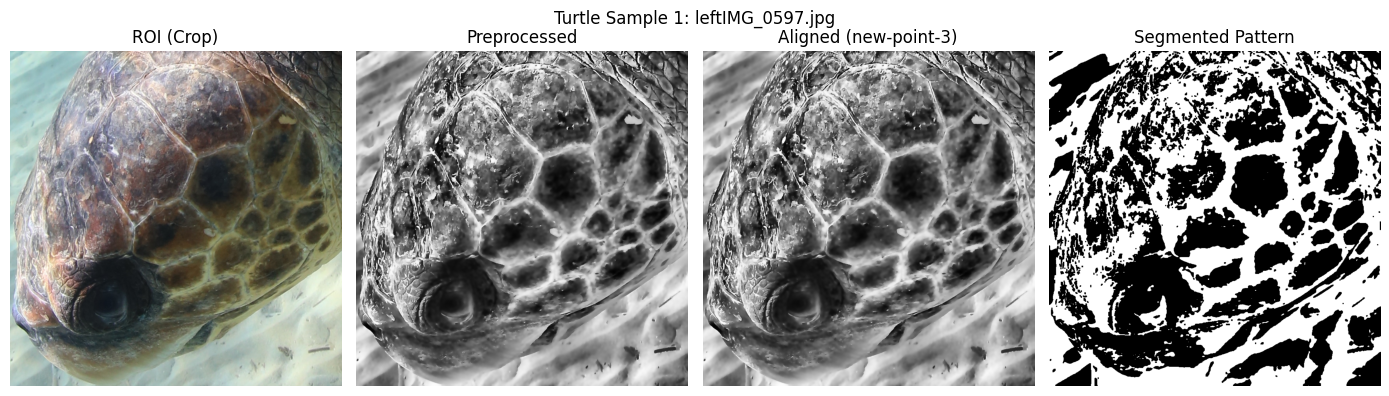


================= ROBFLOW RESULT (compact) =================

📦 Number of detection blocks: 1
🔹 Detection 0: class=left_eye, keypoints=5
   ↳ new-point-0 (conf=0.831) -> (266,115)
   ↳ new-point-1 (conf=0.772) -> (242,76)
   ↳ new-point-2 (conf=0.847) -> (270,24)
   ↳ new-point-3 (conf=0.857) -> (322,36)
   ↳ new-point-4 (conf=0.868) -> (288,92)
↩️ Using method: pair new-point-2 -> new-point-3; vector dx=52.0, dy=12.0, angle=12.99°, rotate by -12.99°


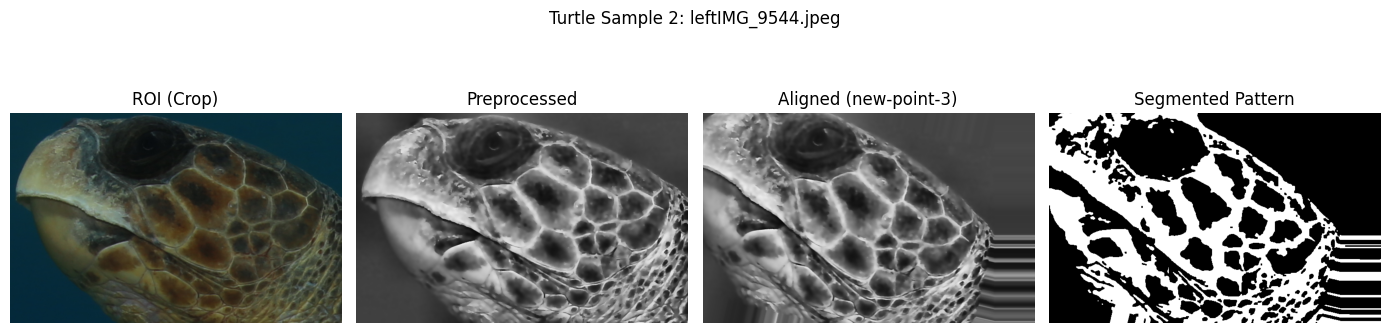


================= ROBFLOW RESULT (compact) =================

📦 Number of detection blocks: 0
⚠️ No keypoints found in detection.
⚠️ No keypoints at all, skipping rotation.


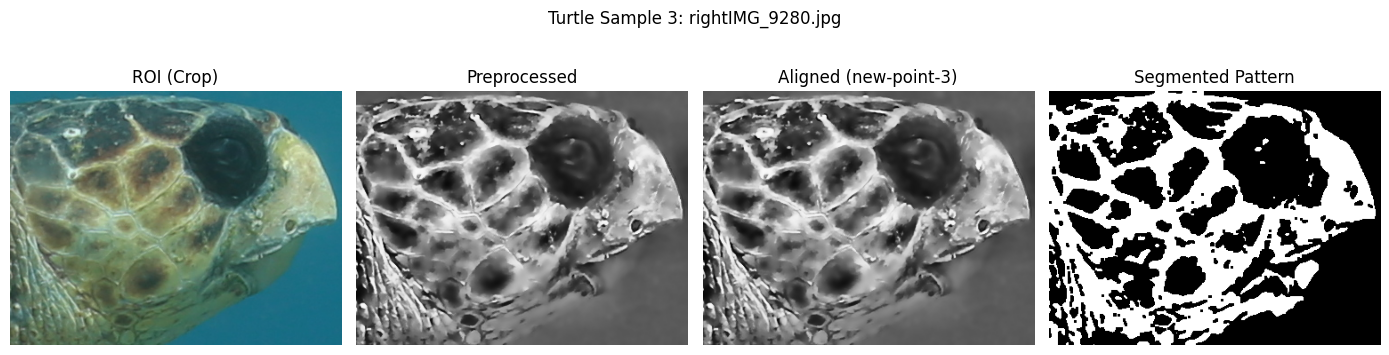


================= ROBFLOW RESULT (compact) =================

📦 Number of detection blocks: 1
🔹 Detection 0: class=nose_tip, keypoints=5
   ↳ new-point-0 (conf=0.837) -> (29,130)
   ↳ new-point-1 (conf=0.911) -> (17,182)
   ↳ new-point-2 (conf=0.837) -> (11,265)
   ↳ new-point-3 (conf=0.874) -> (33,300)
   ↳ new-point-4 (conf=0.724) -> (103,305)
↩️ Using method: pair new-point-2 -> new-point-3; vector dx=22.0, dy=35.0, angle=57.85°, rotate by -57.85°


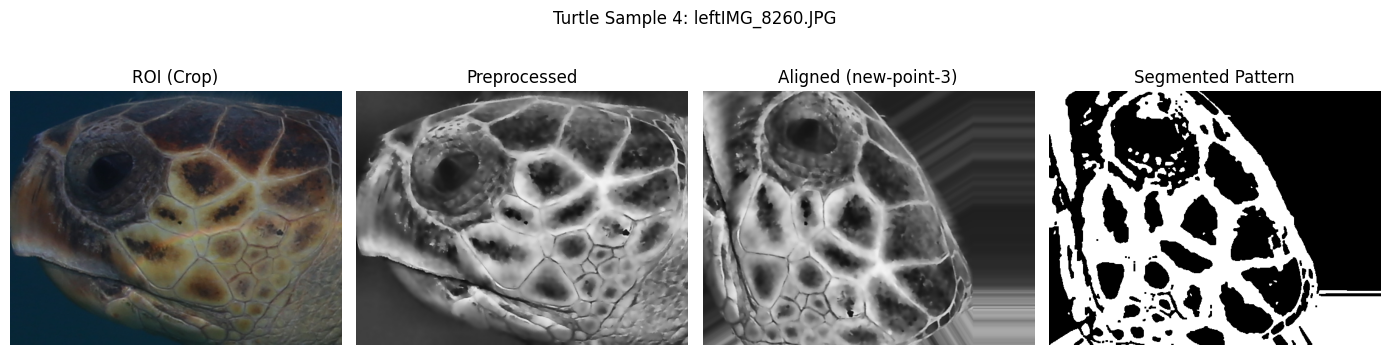

In [11]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
from inference_sdk import InferenceHTTPClient

# --- Define paths ---
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# --- Load metadata ---
df = pd.read_csv(CSV_FILE)
print(f"✅ Loaded {len(df)} records from {CSV_FILE}")

# ============================================================== #
#                      HELPER FUNCTIONS                          #
# ============================================================== #

def preprocess_image(image):
    """Enhance contrast and texture visibility for turtle facial patterns."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    gamma = 0.7 if mean_intensity < 110 else (1.4 if mean_intensity > 160 else 1.0)
    gamma_corrected = np.power(gray / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gamma_corrected)
    blur = cv2.GaussianBlur(enhanced, (7,7), 0)
    sharp = cv2.addWeighted(enhanced, 1.6, blur, -0.6, 0)
    final = cv2.bilateralFilter(sharp, d=9, sigmaColor=35, sigmaSpace=35)
    return final


def get_head_roi(image, bbox):
    """Crop the head ROI from full image."""
    x, y, w, h = [int(v) for v in bbox]
    return image[y:y+h, x:x+w]

def extract_keypoints_block(result_json):
    """
    Return a dict mapping keypoint class -> (x,y,confidence) for the first detection block.
    Also prints debug info.
    """
    # Try both possible top-level paths (some responses use 'output' nesting)
    top = result_json[0].get("predictions") or result_json[0].get("output", {}).get("predictions")
    preds = top["predictions"] if isinstance(top, dict) and "predictions" in top else top

    if isinstance(preds, dict) and "predictions" in preds:
        preds = preds["predictions"]

    kp_map = {}
    print("📦 Number of detection blocks:", len(preds))
    for i, p in enumerate(preds):
        cls = p.get("class")
        kps = p.get("keypoints", [])
        print(f"🔹 Detection {i}: class={cls}, keypoints={len(kps)}")
        for kp in kps:
            name = kp.get("class")
            conf = kp.get("confidence", 0.0)
            x = int(kp.get("x", 0))
            y = int(kp.get("y", 0))
            print(f"   ↳ {name} (conf={conf:.3f}) -> ({x},{y})")
            # store best (highest confidence) if duplicate names appear
            if name not in kp_map or conf > kp_map[name][2]:
                kp_map[name] = (x, y, conf)

    if not kp_map:
        print("⚠️ No keypoints found in detection.")
    return kp_map


def get_keypoints_from_roboflow(roi):
    """Send ROI to Roboflow and return a keypoint map for debugging and alignment."""
    client = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key="njWzK2heOkrQaGgn2CKY"
    )
    tmp_path = "temp_roi.jpg"
    cv2.imwrite(tmp_path, roi)

    try:
        result = client.run_workflow(
            workspace_name="final-project953494-qwata",
            workflow_id="turtle-landmark",
            images={"image": tmp_path},
            use_cache=True
        )
        # DEBUG: print a compact representation (optional)
        print("\n================= ROBFLOW RESULT (compact) =================")
        #print(result)   # if you want the full dump uncomment
        print("===========================================================\n")

        kp_map = extract_keypoints_block(result)
        return kp_map
    except Exception as e:
        print(f"⚠️ Roboflow inference failed: {e}")
        return {}


def rotate_and_align(image, kp_map, prefer_pair=("new-point-2", "new-point-3")):
    """
    Rotate the ROI so that the vector between two chosen keypoints is horizontal.
    If two keypoints are available, use them. If only one is present, fall back to center->point.
    kp_map is a dict: name -> (x,y,conf).
    """
    (h, w) = image.shape[:2]
    center = np.array([w/2.0, h/2.0])

    # Try to use preferred pair
    p1_name, p2_name = prefer_pair
    p1 = kp_map.get(p1_name)
    p2 = kp_map.get(p2_name)

    if p1 and p2:
        # Use vector from p1 -> p2 as orientation
        p1_xy = np.array([p1[0], p1[1]], dtype=float)
        p2_xy = np.array([p2[0], p2[1]], dtype=float)
        vec = p2_xy - p1_xy
        method = f"pair {p1_name} -> {p2_name}"
        ref_point = tuple(p2_xy)  # we'll center p2 horizontally after rotation (optional)
    else:
        # fall back to single keypoint (use highest-confidence keypoint if more than 1)
        if kp_map:
            # choose best (highest confidence)
            best_name, (bx, by, bconf) = max(kp_map.items(), key=lambda it: it[1][2])
            p_center = np.array([bx, by], dtype=float)
            vec = p_center - center
            method = f"center -> {best_name}"
            ref_point = (bx, by)
            print(f"⚠️ Preferred pair missing, using fallback: {best_name} (conf={bconf:.3f})")
        else:
            print("⚠️ No keypoints at all, skipping rotation.")
            return image

    dx, dy = vec[0], vec[1]
    angle = math.degrees(math.atan2(dy, dx))   # angle of the vector relative to +x axis

    # We want to rotate so the vector becomes horizontal (angle -> 0).
    rotation = -angle

    # Normalize rotation to shortest rotation angle (keep in [-90, 90] to avoid flipping)
    if rotation > 90:
        rotation -= 180
    elif rotation < -90:
        rotation += 180

    print(f"↩️ Using method: {method}; vector dx={dx:.1f}, dy={dy:.1f}, angle={angle:.2f}°, rotate by {rotation:.2f}°")

    # Rotate around image center
    M = cv2.getRotationMatrix2D((center[0], center[1]), rotation, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Optional: horizontally center ref_point after rotation (keep vertical unchanged)
    if ref_point is not None:
        ref = np.array(ref_point, dtype=float)
        # transform ref through rotation matrix (2x2 * (ref - center) + t + center)
        ref_rot = np.dot(M[:, :2], (ref - center)) + M[:, 2] + center
        tx = center[0] - ref_rot[0]
        ty = 0  # don't shift vertical
        M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
        final = cv2.warpAffine(rotated, M_translate, (w, h), borderMode=cv2.BORDER_REPLICATE)
    else:
        final = rotated

    return final


def segment_pattern(image):
    """Segment the turtle's facial pattern (texture mask)."""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=30, sigmaSpace=30)
    _, segmented = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)
    segmented = cv2.GaussianBlur(segmented, (3,3), 0.3)
    segmented = cv2.dilate(segmented, np.ones((1,1), np.uint8), iterations=1)
    return segmented

# ============================================================== #
#                 MAIN VISUALIZATION LOOP                        #
# ============================================================== #

samples = df.sample(4, random_state=42)
plt.figure(figsize=(16, 12))

for i, row in enumerate(samples.itertuples(), 1):
    img_path = os.path.join(IMAGE_DIR, row.path)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing image: {img_path}")
        continue

    image = cv2.imread(img_path)
    roi = get_head_roi(image, [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height])
    preprocessed = preprocess_image(roi)

    ref_point = get_keypoints_from_roboflow(preprocessed)
    if ref_point is None:
        print(f"⚠️ Missing keypoint for {row.path}, skipping.")
        continue

    rotated = rotate_and_align(preprocessed, ref_point)
    segmented = segment_pattern(rotated)

    # Plot processing stages
    stages = [roi, preprocessed, rotated, segmented]
    titles = ['ROI (Crop)', 'Preprocessed', 'Aligned (new-point-3)', 'Segmented Pattern']

    plt.figure(figsize=(14, 4))
    for j in range(4):
        plt.subplot(1, 4, j+1)
        if j < 3:
            plt.imshow(cv2.cvtColor(stages[j], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(stages[j], cmap='gray')
        plt.title(titles[j])
        plt.axis('off')
    plt.suptitle(f"Turtle Sample {i}: {row.path}")
    plt.tight_layout()
    plt.show()

In [53]:
import pandas as pd
import numpy as np
import cv2, os, math, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from inference_sdk import InferenceHTTPClient

# ================= CONFIG =================
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# Load merged data
df = pd.read_csv(CSV_FILE)
print(f"✅ Loaded {len(df)} samples from {CSV_FILE}")

# ================= HELPERS =================
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    gamma = 0.7 if mean_intensity < 110 else (1.4 if mean_intensity > 160 else 1.0)
    corrected = np.power(gray / 255.0, gamma) * 255
    corrected = corrected.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(corrected)
    blur = cv2.GaussianBlur(enhanced, (7,7), 0)
    sharp = cv2.addWeighted(enhanced, 1.6, blur, -0.6, 0)
    return cv2.bilateralFilter(sharp, 9, 35, 35)

def get_head_roi(image, bbox):
    x, y, w, h = map(int, bbox)
    return image[y:y+h, x:x+w]

def segment_pattern(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    filtered = cv2.bilateralFilter(enhanced, 5, 30, 30)
    _, seg = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    seg = cv2.morphologyEx(seg, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    return seg

def get_reference_point(image):
    """
    Use Roboflow inference to get keypoints for the turtle head,
    and return coordinates of 'new-point-3' (alignment reference).
    """
    client = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key="njWzK2heOkrQaGgn2CKY"
    )
    tmp = "temp.jpg"
    cv2.imwrite(tmp, image)
    try:
        result = client.run_workflow(
            workspace_name="final-project953494-qwata",
            workflow_id="turtle-landmark",
            images={"image": tmp},
            use_cache=True
        )
        preds = result[0]["predictions"]["predictions"]
        for p in preds:
            if p["class"] == "head" and p.get("keypoints"):
                for kp in p["keypoints"]:
                    if kp["class"] == "new-point-3":
                        return int(kp["x"]), int(kp["y"])
    except Exception as e:
        print(f"Roboflow error: {e}")
    return None


def rotate_align(image, ref_point):
    """
    Rotate the image so that the reference point (new-point-3)
    lies horizontally centered relative to the image center.
    """
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    if not ref_point:
        return image

    # Calculate rotation angle to align horizontally
    dx, dy = ref_point[0] - center[0], ref_point[1] - center[1]
    angle = math.degrees(math.atan2(dy, dx))

    # Rotate around the image center to align horizontally
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Optional: translate the point to the horizontal center
    # so that the reference point becomes centered
    ref_point_rot = np.dot(M[:, :2], np.array(ref_point) - np.array(center)) + M[:, 2] + np.array(center)
    tx = center[0] - ref_point_rot[0]
    ty = center[1] - ref_point_rot[1]
    M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
    aligned = cv2.warpAffine(rotated, M_translate, (w, h), borderMode=cv2.BORDER_REPLICATE)

    return aligned

def extract_features(image):
    # ORB + Hu Moments combination
    orb = cv2.ORB_create(nfeatures=500)
    kp, des = orb.detectAndCompute(image, None)
    if des is None:
        des = np.zeros((1, 32))
    hu = -np.sign(cv2.HuMoments(cv2.moments(image)).flatten()) * np.log10(np.abs(cv2.HuMoments(cv2.moments(image)).flatten()) + 1e-10)
    return np.hstack([hu, np.mean(des, axis=0)])

# ================= PIPELINE =================
X, y = [], []
for row in df.itertuples():
    img_path = os.path.join(IMAGE_DIR, row.path)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing: {img_path}")
        continue

    img = cv2.imread(img_path)
    roi = get_head_roi(img, [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height])
    pre = preprocess_image(roi)
    nose = get_reference_point(pre)
    aligned = rotate_align(pre, nose)
    seg = segment_pattern(aligned)
    feat = extract_features(seg)
    X.append(feat)
    y.append(row.turtle_id)  # <-- must exist in your CSV

X, y = np.array(X), np.array(y)
print(f"✅ Extracted {X.shape[0]} samples with {X.shape[1]} features")

# ================= TRAIN & EVALUATE =================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

model = SVC(kernel='rbf', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

# ================= SAVE MODEL =================
import joblib
joblib.dump(model, "turtle_id_model.pkl")
print("💾 Model saved as 'turtle_id_model.pkl'")


✅ Loaded 160 samples from content/merged_turtle_data.csv


AttributeError: 'Pandas' object has no attribute 'turtle_id'

In [51]:

"""Send ROI image to Roboflow turtle-landmark model and return (left_eye, right_eye, nose_tip)."""
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="njWzK2heOkrQaGgn2CKY"
)

# Save temporary ROI to send to API
tmp_path = "temp_roi.jpg"
cv2.imwrite(tmp_path, roi)

result = client.run_workflow(
    workspace_name="final-project953494-qwata",
    workflow_id="turtle-landmark",
    images={"image": tmp_path},
    use_cache=True
)
left_eye, right_eye, nose_tip = extract_turtle_keypoints(result)
        
print("Left Eye:", left_eye)
print("Right Eye:", right_eye) 
print("Nose Tip:", nose_tip)

🔍 Detected classes: ['left_eye', 'nose_tip']


ValueError: not enough values to unpack (expected 3, got 2)

--- Running 4 Random Turtle Pipeline Examples ---


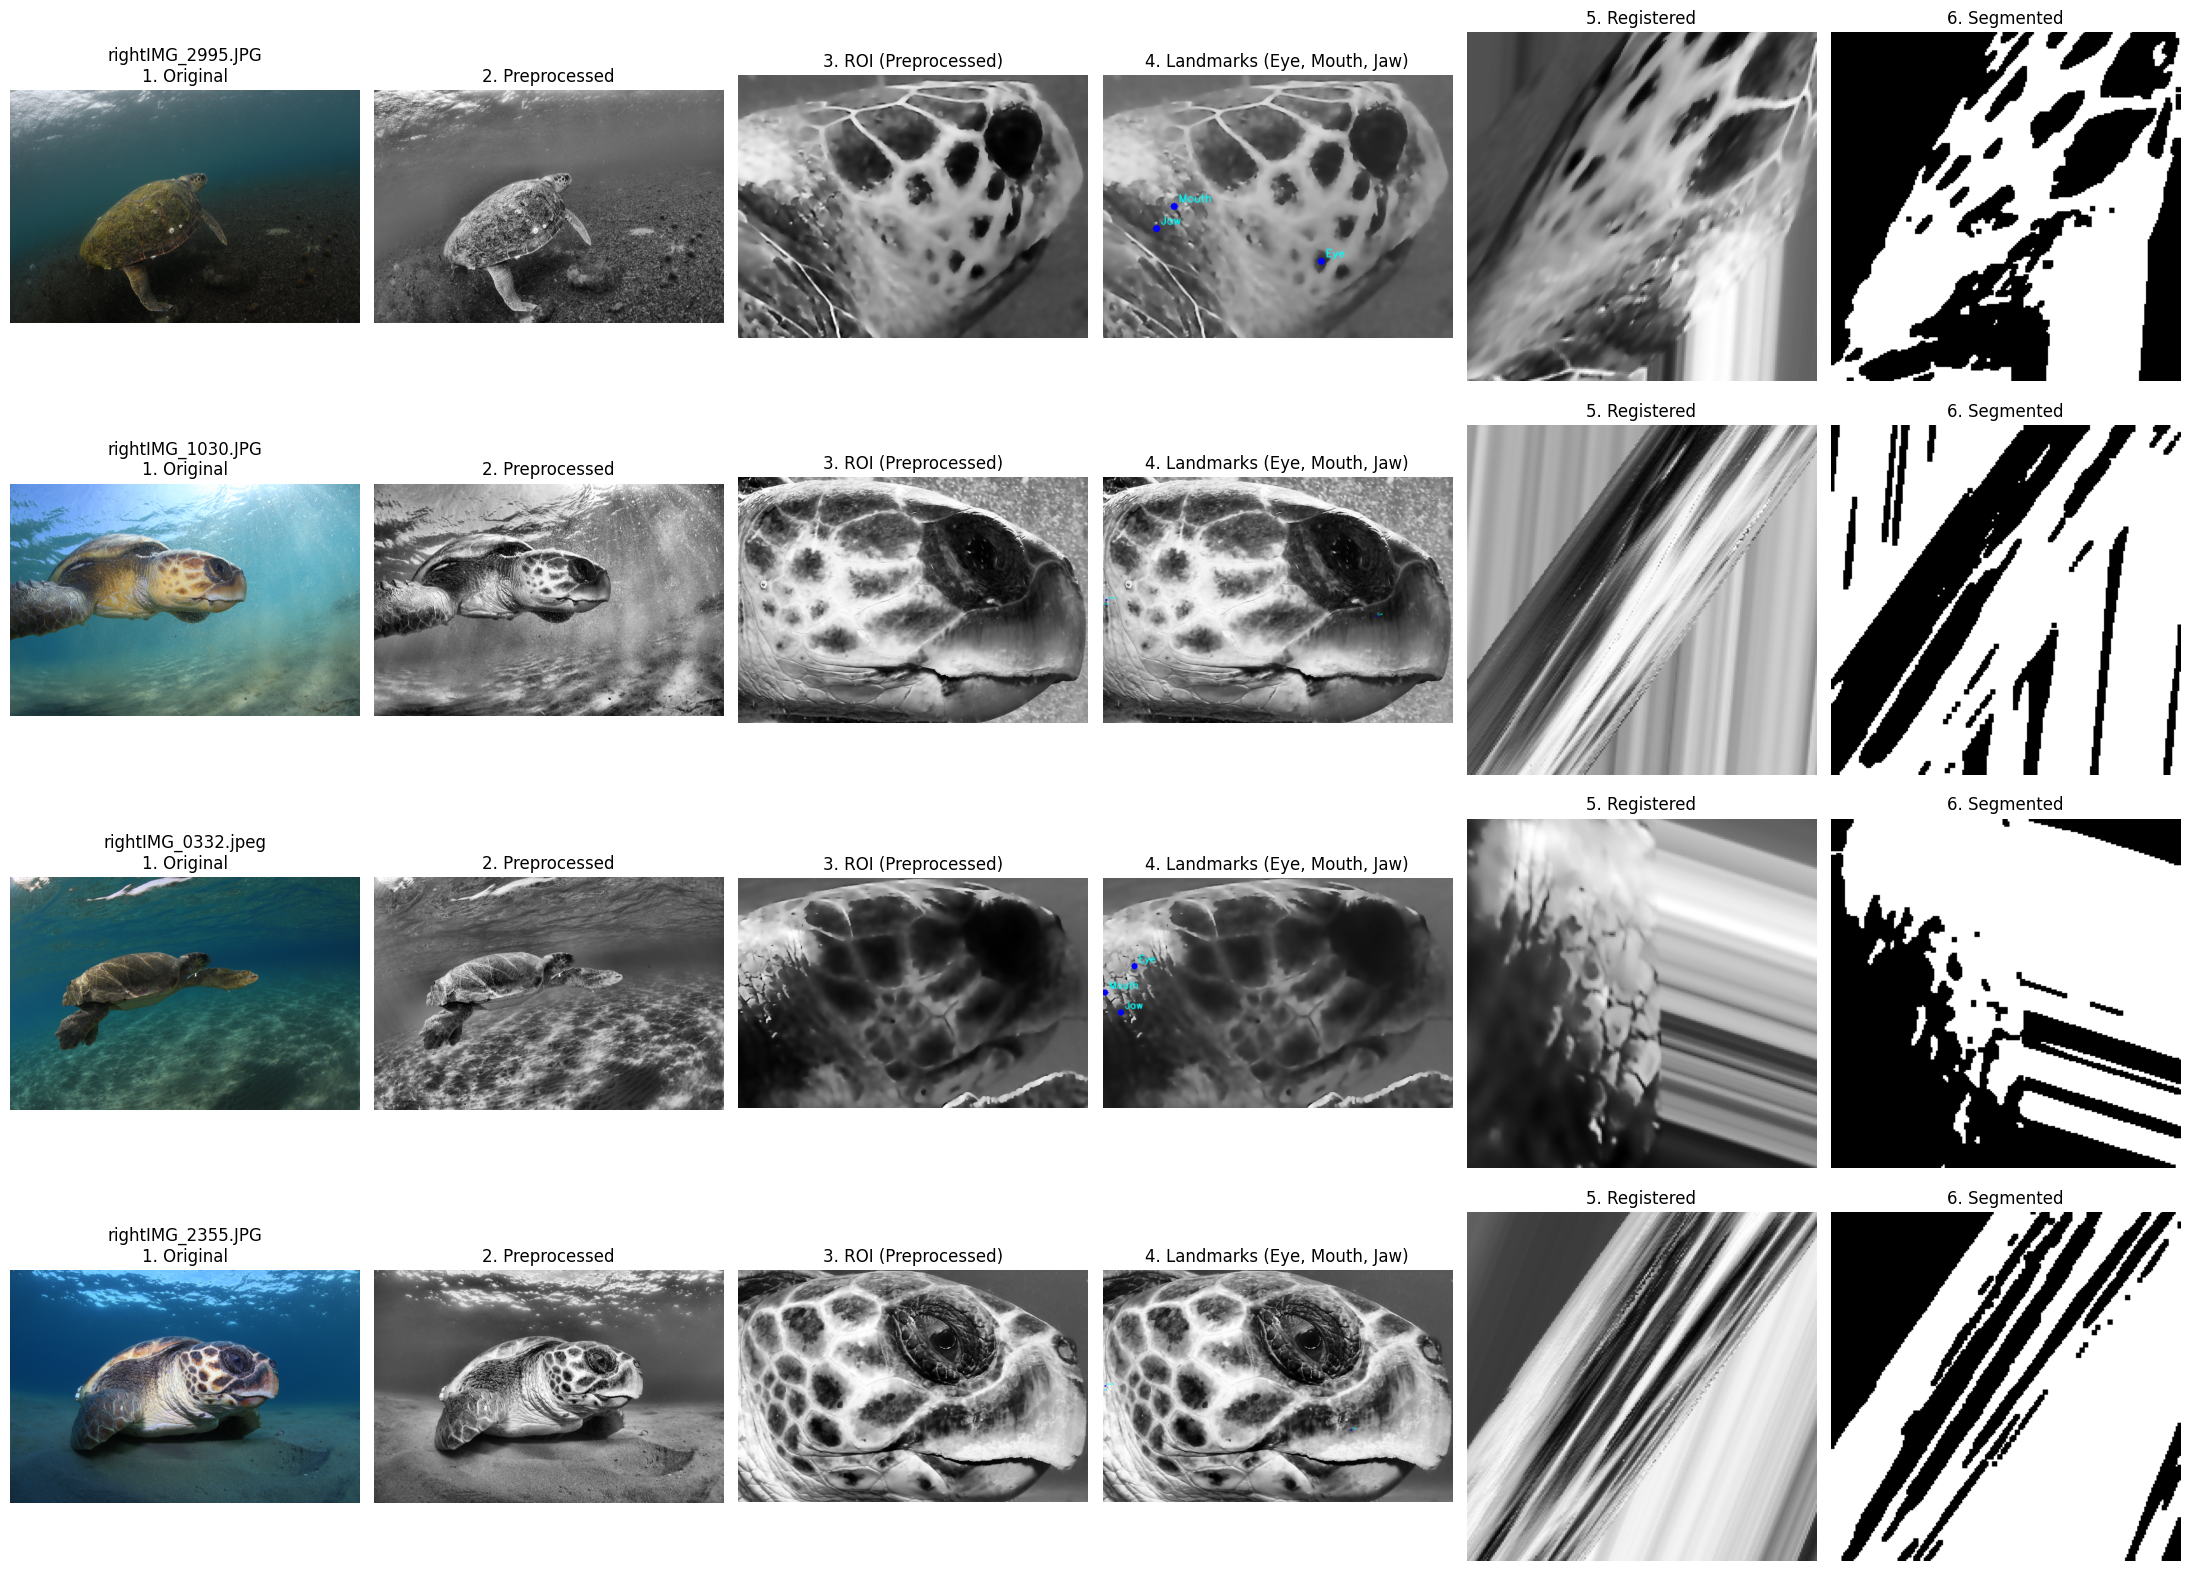

✅ Saved 'pipeline_4_examples_profile_turtles.png'


In [ ]:
import random
import matplotlib.pyplot as plt

# --- UPDATED DEMONSTRATION FUNCTION ---
def demonstrate_pipeline(row):
    """
    Runs one image through the full pipeline (Steps 1–5)
    and returns intermediate images (ROI, landmarks, registered, segmented)
    for visualization.
    """
    results = {"name": None, "roi_color": None, "roi_with_landmarks": None, 
               "registered": None, "segmented": None}

    try:
        image_name = row['image_name']
        image_path = os.path.join(IMAGE_DIR, image_name)
        orientation = row['orientation']
        bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
        results["name"] = image_name

        # --- 1️⃣ Load original ---
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"⚠️ Could not load image {image_path}")
            return None
        results["original"] = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # --- 2️⃣ Preprocess full image ---
        preprocessed_full = preprocess_image(original_image)
        results["preprocessed"] = preprocessed_full

        # --- 3️⃣ Extract ROI from preprocessed ---
        roi_gray = get_head_roi(preprocessed_full, bbox)
        roi_color = get_head_roi(original_image, bbox)
        results["roi"] = roi_gray

        # --- 4️⃣ Find landmarks ---
        detected_landmarks = find_landmarks(roi_color)
        if detected_landmarks is None:
            print(f"⚠️ No landmarks found for {image_name}")
            return None

        # Draw landmarks + labels
        roi_vis = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)
        labels = ["Eye", "Mouth", "Jaw"]
        for (pt, label) in zip(detected_landmarks, labels):
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(roi_vis, (x, y), 4, (255, 0, 0), -1)
            cv2.putText(
                roi_vis, label, (x + 5, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1, cv2.LINE_AA
            )
        results["roi_landmarks"] = cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB)

        # --- 5️⃣ Register / align ---
        if orientation.lower() == "left":
            target_landmarks = CANONICAL_LANDMARKS_LEFT
        else:
            target_landmarks = CANONICAL_LANDMARKS_RIGHT
        results["registered"] = register_head(roi_gray, detected_landmarks, target_landmarks)

        # --- 6️⃣ Segment ---
        results["segmented"] = segment_pattern(results["registered"])
        return results

    except Exception as e:
        print(f"❌ Error processing {row.get('image_name', 'unknown')}: {e}")
        return None


# --- RUN RANDOM 4 EXAMPLES ---
if 'df' in locals() and not df.empty:
    print("--- Running 4 Random Turtle Pipeline Examples ---")
    sample_rows = df.sample(4, random_state=random.randint(0, 99999)).reset_index(drop=True)

    fig, axes = plt.subplots(4, 6, figsize=(22, 16))

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        res = demonstrate_pipeline(row)
        if res is None:
            continue

        axes[i, 0].imshow(res["original"])
        axes[i, 0].set_title(f"{res['name']}\n1. Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(res["preprocessed"], cmap='gray')
        axes[i, 1].set_title("2. Preprocessed")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(res["roi"], cmap='gray')
        axes[i, 2].set_title("3. ROI (Preprocessed)")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(res["roi_landmarks"])
        axes[i, 3].set_title("4. Landmarks (Eye, Mouth, Jaw)")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(res["registered"], cmap='gray')
        axes[i, 4].set_title("5. Registered")
        axes[i, 4].axis('off')

        axes[i, 5].imshow(res["segmented"], cmap='gray')
        axes[i, 5].set_title("6. Segmented")
        axes[i, 5].axis('off')

    plt.tight_layout()
    plt.savefig("pipeline_4_examples_profile_turtles.png", dpi=200)
    plt.show()
    print("✅ Saved 'pipeline_4_examples_profile_turtles.png'")
else:
    print("⚠️ Skipping demonstration — 'df' not loaded or empty.")

**Step 5: Pattern Recognition**

In [ ]:
print("--- Initializing Step 5 (Pattern Recognition) ---")

# Initialize the ORB detector
# We'll try to find up to 2000 key features in each image.
try:
    orb = cv2.ORB_create(nfeatures=2000)
    print("ORB Detector created.")
except Exception as e:
    print(f"Error creating ORB detector. Make sure your OpenCV version is correct. {e}")


# 1. Create the Feature Database
def create_feature_database(df_train):
    """
    Processes all images in the training set and stores
    their features (keypoints & descriptors) in a list.
    """
    print(f"\nCreating feature database for {len(df_train)} training images...")
    feature_database = []
    
    for index, row in df_train.iterrows():
        try:
            image_name = row['image_name']
            image_path = os.path.join(IMAGE_DIR, image_name)
            
            # Load the original image
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Could not load {image_path} for database. Skipping.")
                continue

            # --- Run Steps 1-3 from our pipeline ---
            # We use the advanced pre-processing function if you have it
            # Or the standard 'preprocess_image' function
            preprocessed_full = preprocess_image(original_image)
            
            bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
            roi_gray = get_head_roi(preprocessed_full, bbox)
            roi_registered = register_head(roi_gray, row['orientation'])
            
            # --- Feature Extraction (Step 5a) ---
            # Find keypoints and descriptors with ORB
            # We use the pre-processed (gray, registered) ROI,
            # NOT the segmented one, as ORB needs texture.
            keypoints, descriptors = orb.detectAndCompute(roi_registered, None)
            
            if descriptors is not None and len(descriptors) > 0:
                feature_database.append({
                    'identity': row['identity'],
                    'image_name': image_name,
                    'descriptors': descriptors
                })
            else:
                print(f"Warning: No descriptors found for {image_name}. Skipping.")
                
        except Exception as e:
            print(f"Error during feature extraction for {image_name}: {e}")
            
    print(f"Database creation complete. Stored features for {len(feature_database)} images.")
    return feature_database


# 2. Match a Test Image against the Database
def identify_turtle(test_image_processed, database):
    """
    Finds the best match for a new test image
    against the feature database.
    """
    # Initialize the Brute-Force Matcher
    # cv2.NORM_HAMMING is the correct distance measure for ORB
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Find features in the *test* image
    test_kp, test_desc = orb.detectAndCompute(test_image_processed, None)
    
    if test_desc is None or len(test_desc) == 0:
        # print("Could not find any features in the test image.")
        return None # No features to match

    all_matches_by_identity = {}
    
    # Loop through every image in our database
    for db_entry in database:
        db_desc = db_entry['descriptors']
        db_identity = db_entry['identity']
        
        try:
            # Find matches between test image and this database image
            matches = bf.match(test_desc, db_desc)
            
            # Keep only "good" matches
            # A good match is one with a low "distance".
            # For ORB, a distance < 50 is a common starting point.
            # You can TUNE this value to get better results.
            good_matches = [m for m in matches if m.distance < 50]
            
            num_good_matches = len(good_matches)
            
            # --- This is a more robust way to score ---
            # We sum the matches for each IDENTITY, not just each image.
            # This prevents one lucky match from skewing the result.
            if db_identity not in all_matches_by_identity:
                all_matches_by_identity[db_identity] = 0
            
            all_matches_by_identity[db_identity] += num_good_matches

        except cv2.error as e:
            # This can happen if descriptor formats mismatch, etc.
            # print(f"Matcher error comparing with {db_entry['image_name']}: {e}")
            pass

    if not all_matches_by_identity:
        # print("No good matches found against the entire database.")
        return None

    # Sort all results by the number of good matches (descending)
    sorted_results = sorted(
        all_matches_by_identity.items(), 
        key=lambda item: item[1],  # item[1] is the number of matches
        reverse=True
    )
    
    # The top result is our prediction
    # Format: [('turtle_id_A', 150), ('turtle_id_B', 95), ...]
    return sorted_results

--- Initializing Step 5 (Pattern Recognition) ---
ORB Detector created.


**Step 6: Evaluation**

In [5]:
import pandas as pd
import numpy as np
import cv2, os, math, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from inference_sdk import InferenceHTTPClient
from sklearn.metrics import precision_recall_fscore_support

# ================= CONFIG =================
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# Load merged data
df = pd.read_csv(CSV_FILE)
print(f"✅ Loaded {len(df)} samples from {CSV_FILE}")

# ================= HELPERS =================
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    gamma = 0.7 if mean_intensity < 110 else (1.4 if mean_intensity > 160 else 1.0)
    corrected = np.power(gray / 255.0, gamma) * 255
    corrected = corrected.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(corrected)
    blur = cv2.GaussianBlur(enhanced, (7,7), 0)
    sharp = cv2.addWeighted(enhanced, 1.6, blur, -0.6, 0)
    return cv2.bilateralFilter(sharp, 9, 35, 35)

def get_head_roi(image, bbox):
    x, y, w, h = map(int, bbox)
    return image[y:y+h, x:x+w]

def segment_pattern(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    filtered = cv2.bilateralFilter(enhanced, 5, 30, 30)
    _, seg = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    seg = cv2.morphologyEx(seg, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    return seg

def get_reference_point(image):
    """
    Use Roboflow inference to get keypoints for the turtle head,
    and return coordinates of 'new-point-3' (alignment reference).
    """
    client = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key="njWzK2heOkrQaGgn2CKY"
    )
    tmp = "temp.jpg"
    cv2.imwrite(tmp, image)
    try:
        result = client.run_workflow(
            workspace_name="final-project953494-qwata",
            workflow_id="turtle-landmark",
            images={"image": tmp},
            use_cache=True
        )
        preds = result[0]["predictions"]["predictions"]
        for p in preds:
            if p["class"] == "head" and p.get("keypoints"):
                for kp in p["keypoints"]:
                    if kp["class"] == "new-point-3":
                        return int(kp["x"]), int(kp["y"])
    except Exception as e:
        print(f"Roboflow error: {e}")
    return None

def rotate_align(image, ref_point):
    """
    Rotate the image so that the reference point (new-point-3)
    lies horizontally centered relative to the image center.
    """
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    if not ref_point:
        return image

    # Calculate rotation angle to align horizontally
    dx, dy = ref_point[0] - center[0], ref_point[1] - center[1]
    angle = math.degrees(math.atan2(dy, dx))

    # Rotate around the image center to align horizontally
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Optional: translate the point to the horizontal center
    # so that the reference point becomes centered
    ref_point_rot = np.dot(M[:, :2], np.array(ref_point) - np.array(center)) + M[:, 2] + np.array(center)
    tx = center[0] - ref_point_rot[0]
    ty = center[1] - ref_point_rot[1]
    M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
    aligned = cv2.warpAffine(rotated, M_translate, (w, h), borderMode=cv2.BORDER_REPLICATE)

    return aligned

def extract_features(image):
    # ORB + Hu Moments combination
    orb = cv2.ORB_create(nfeatures=500)
    kp, des = orb.detectAndCompute(image, None)
    if des is None:
        des = np.zeros((1, 32))
    hu = -np.sign(cv2.HuMoments(cv2.moments(image)).flatten()) * np.log10(np.abs(cv2.HuMoments(cv2.moments(image)).flatten()) + 1e-10)
    return np.hstack([hu, np.mean(des, axis=0)])

# ================= PIPELINE =================
X, y = [], []

for row in df.itertuples(index=False):
    img_path = os.path.join(IMAGE_DIR, row.path)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing: {img_path}")
        continue

    # --- Read and crop ROI ---
    img = cv2.imread(img_path)
    roi = get_head_roi(img, [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height])

    # --- Preprocess ---
    pre = preprocess_image(roi)

    # --- Alignment using reference point (nose_tip or landmark) ---
    ref_point = get_reference_point(pre)
    aligned = rotate_align(pre, ref_point)

    # --- Segmentation ---
    seg = segment_pattern(aligned)

    # --- Feature extraction ---
    feat = extract_features(seg)
    X.append(feat)
    y.append(row.identity)  # use identity column as the label

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

print(f"✅ Extracted {X.shape[0]} samples with {X.shape[1]} features across {len(np.unique(y))} turtle identities.")

# ================= TRAIN & EVALUATE =================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

model = SVC(kernel='rbf', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("\n📊 Overall Performance (macro-averaged):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred)*100:.2f}%")

# ================= SAVE MODEL =================
import joblib
joblib.dump(model, "turtle_id_model.pkl")
print("💾 Model saved as 'turtle_id_model.pkl'")


✅ Loaded 160 samples from content/merged_turtle_data.csv
✅ Extracted 160 samples with 39 features across 40 turtle identities.

📊 Overall Performance (macro-averaged):
Precision: 0.0500
Recall:    0.0500
F1-score:  0.0500
Accuracy:  5.00%
💾 Model saved as 'turtle_id_model.pkl'


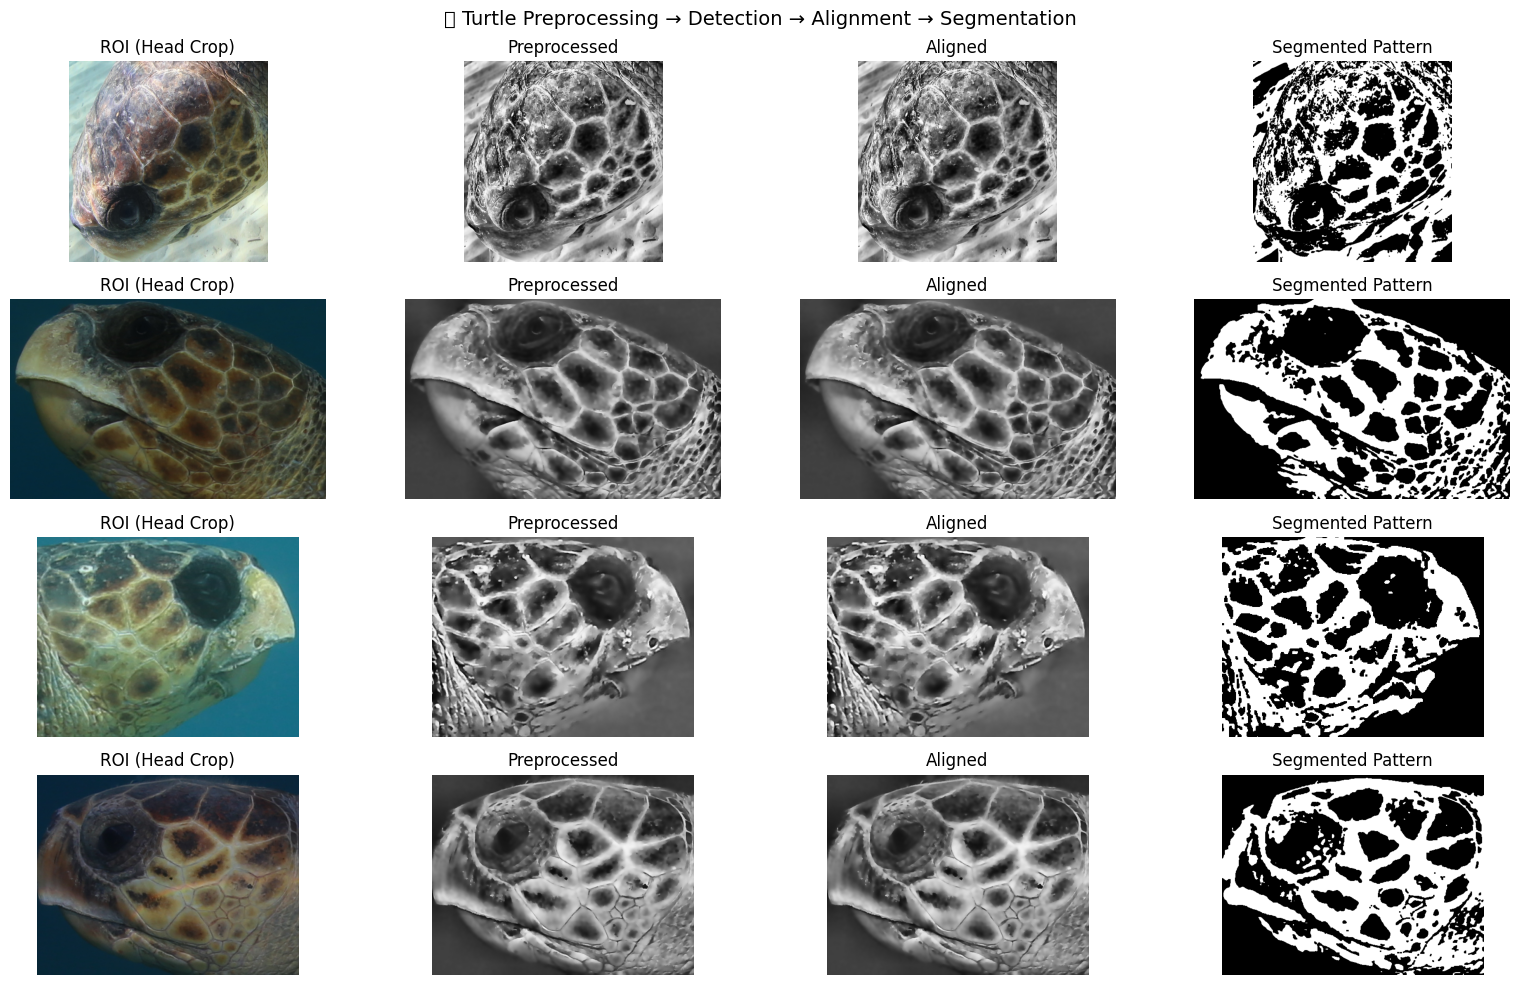

In [3]:
# ================= VISUALIZATION OF 4 EXAMPLES =================
import random

# Pick 4 random samples
samples = df.sample(4, random_state=42)
plt.figure(figsize=(16, 10))

for i, row in enumerate(samples.itertuples(), 1):
    img_path = os.path.join(IMAGE_DIR, row.path)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing image: {img_path}")
        continue

    # 1️⃣ Read and crop ROI
    image = cv2.imread(img_path)
    roi = get_head_roi(image, [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height])

    # 2️⃣ Preprocess
    pre = preprocess_image(roi)

    # 3️⃣ Alignment (reference point from Roboflow)
    ref_point = get_reference_point(pre)
    aligned = rotate_align(pre, ref_point)

    # 4️⃣ Segmentation
    segmented = segment_pattern(aligned)

    # 5️⃣ Prepare for display
    stages = [roi, pre, aligned, segmented]
    titles = ['ROI (Head Crop)', 'Preprocessed', 'Aligned', 'Segmented Pattern']

    for j in range(4):
        plt.subplot(4, 4, (i-1)*4 + j + 1)
        if j < 3:
            plt.imshow(cv2.cvtColor(stages[j], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(stages[j], cmap='gray')
        plt.title(titles[j])
        plt.axis('off')

plt.suptitle("🐢 Turtle Preprocessing → Detection → Alignment → Segmentation", fontsize=14)
plt.tight_layout()
plt.show()